# CSCI 4022 Final Project 
By John Danekind and Daniel Hatakeyama

## Import Stuff


In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn 
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import pyminhash

# We have to implement our own version of the algorithms

In [2]:
# Make subset of files since they are huge 
# Name file something different 

def make_subset(input_path, output_path):
    # Read in file 
    df = pd.read_csv(input_path)
    
    # Get a random sample of 1000 rows 
    df_sample = df.sample(n=1000, random_state=42)
    
    # Save the sample to a new file and give it a different name
    output_path = os.path.join(os.path.dirname(input_path), 'sampled_' + os.path.basename(input_path)) 
    new_file = df_sample.to_csv(output_path)
    
    return new_file

make_subset('../data/True.csv', '../data/sample_True.csv')
make_subset('../data/Fake.csv', '../data/sample_Fake.csv')



### Ideal questions to consider for now
- Can unsupervised clustering naturally separate fake from real news without using labels?
- What distinctive linguistic patterns emerge in clusters of fake vs. real news?
- Are there identifiable sub-categories within fake news that clustering can reveal?
- How do temporal patterns differ between fake and real news clusters?
- Which textual features most strongly contribute to the separation of clusters?


#### Things to think about
- Dataset is meant for more supervised learning tasks (Neural nets, svms, knn, etc)
- Maybe use KMeans, minhashing, and GMM's to cluster news into different categories
- Compare these clusters to the labels later 


#### Current plan since we have no time lmao
- Make datasets into one big dataset with no labels.
- Do K means on that data and cluster articles by similarity (could be jaccard, euclidean with vector embeddings, something else (figure out later))
- See what patterns arise from this. 
- Then take the regular data set and do a simple supervised method that is interpretable. (Logistic regression, random forest. NO BLACK BOX)
- Compare how each of the methods performed. 
- Can fake vs real news be clustered without explicit labels or is it harder to detect?

### Research Question: 
- Can document similarity patterns reveal distinctions between fake and real news? 
- If we cluster documents by some similarity measure into real and fake will this be accurate against the actual dataset? 


## Data Preparation/Preprocessing

#### Loading Data

In [3]:
# Load the data sets
fake_df = pd.read_csv('../data/sampled_Fake.csv')
real_df = pd.read_csv('../data/sampled_True.csv')

# Add labels 
fake_df['label'] = 0
real_df['label'] = 1

# Combine the data sets 
df = pd.concat([fake_df, real_df], ignore_index=True)

# Create a combined text field
df['content'] = df['title'] + ' ' + df['text']

print(f"Total articles: {len(df)}")
print(f"Fake: {len(fake_df)}, Real: {len(real_df)}")

print(f"Fake example: {df['content'].iloc[0]}")
print(f"Real example: {df[df['label'] == 1]['content'].iloc[0]}")

# Shuffle the data 
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

df.head(10)

Total articles: 2000
Fake: 1000, Real: 1000
Fake example: ABOUT HILLARY’S COUGH: We Discovered The Secret To Why She Keeps Coughing [Video]  
Real example: Europe rights watchdog says Turkey's emergency laws go too far BRUSSELS (Reuters) - A leading European rights watchdog called on Turkey on Friday to ease post-coup state of emergency laws that have seen thousands arrested and restore power to regional authorities. President Tayyip Erdogan has overseen a mass purge in the armed forces and the judiciary, as well as a crackdown on critics including academics and journalists since a failed military coup in July last year.  An advisory body to the Council of Europe, of which Turkey is a member, acknowledged in a report  the need for certain extraordinary steps taken by Turkish authorities to face a dangerous armed conspiracy .  However...Turkish authorities have interpreted these extraordinary powers too extensively,  said the experts, known as the Venice Commission, in an opinion that h

,Unnamed: 0,title,text,subject,date,label,content
0,1052,Supreme Court dismisses Hawaii's challenge to ...,WASHINGTON (Reuters) - The U.S. Supreme Court ...,politicsNews,"October 24, 2017",1,Supreme Court dismisses Hawaii's challenge to ...
1,6120,Bernie Sanders Lets Chuck Todd Know If He’s W...,With the Democratic primary process drawing to...,News,"May 29, 2016",0,Bernie Sanders Lets Chuck Todd Know If He’s W...
2,8611,Activist Steyer expands agenda in bid to defea...,PHILADELPHIA (Reuters) - Billionaire environme...,politicsNews,"July 27, 2016",1,Activist Steyer expands agenda in bid to defea...
3,19073,SERIOUSLY? PRO-ILLEGAL ALIEN Supporters Demand...,The video begins with a clearly agitated pro-i...,left-news,"Feb 27, 2017",0,SERIOUSLY? PRO-ILLEGAL ALIEN Supporters Demand...
4,7500,Former President George W. Bush does not cast ...,"AUSTIN, Texas (Reuters) - Former Republican Pr...",politicsNews,"November 8, 2016",1,Former President George W. Bush does not cast ...
5,1768,Factbox: Trump on Twitter (Sept 13) - Tax refo...,The following statements were posted to the ve...,politicsNews,"September 13, 2017",1,Factbox: Trump on Twitter (Sept 13) - Tax refo...
6,12346,WORLD’S MOST FAMOUS VICTIMS Purchase Stunning ...,The Obamas are moving into a nine-bedroom mans...,politics,"Nov 20, 2016",0,WORLD’S MOST FAMOUS VICTIMS Purchase Stunning ...
7,12864,Man with Palestinian flag smashes Jewish resta...,AMSTERDAM (Reuters) - A man with a Palestinian...,worldnews,"December 7, 2017",1,Man with Palestinian flag smashes Jewish resta...
8,11733,INSIDE TRUMP’S CHARITY BALL Tonight At Beautif...,Trump on immigration appeal: We ll win. For t...,politics,"Feb 4, 2017",0,INSIDE TRUMP’S CHARITY BALL Tonight At Beautif...
9,8262,U.S. gives Laos extra $90 million to help clea...,VIENTIANE (Reuters) - The United States announ...,politicsNews,"September 6, 2016",1,U.S. gives Laos extra $90 million to help clea...


#### Text Preprocessing

#### Text Processing pipeline (Look into more later )

In [4]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download required NLTK data (only needs to run once)
#nltk.download('stopwords')
#nltk.download('wordnet')

# Initialize lemmatizer and stopwords
# Lemmatization is the process of converting a word to its base form 
# e.g. 'running' -> 'run'
# Stop words are common words in a language that are usually filtered out
# e.g. 'the', 'a', 'is', etc.
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
print(f"Stop words: {stop_words}")

def preprocess_text(text):
    # Convert the text to all
    text = str(text).lower()
    
    # Remove special characters, numbers, punctuation
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    
    # Tokenize
    tokens = text.split()
    
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    
    # Rejoin tokens
    return ' '.join(tokens)

# Apply preprocessing
df['processed_content'] = df['content'].apply(preprocess_text)
df.head()

Stop words: {'ma', 'off', 'a', 'be', 'such', "he's", 'shan', "mustn't", 'by', 'both', 'has', 'myself', 'she', "we've", 'once', 'your', 'her', 'it', 'yourselves', "couldn't", "hasn't", 'other', "weren't", "won't", 'am', 'up', "wasn't", 'i', 'was', 'that', "i'd", 'didn', 'each', 'few', 'haven', 'over', 'do', 'did', 'd', 'mightn', 'and', "hadn't", 'should', 'in', "he'll", "didn't", 'have', "you've", 'on', "they'd", 'very', 'any', 'been', 'this', 'being', 'isn', 'wasn', 'because', 'same', "mightn't", 'before', 'y', "haven't", 'o', 'to', "we'll", 'but', 'you', 'so', 'nor', 'will', "you'd", 'his', 'needn', 'why', 'into', 'll', "isn't", 'wouldn', 'doing', "that'll", 'until', 'ours', 'which', 'theirs', 'after', 'were', 'yourself', 'who', 'couldn', "it'll", 'no', "needn't", 'an', 'between', 'him', "she's", 'with', "don't", 'having', 'while', 'under', 'against', "you'll", 'he', 'when', 'now', 'is', 'out', 'their', 'above', "she'll", 'about', 'm', 'most', 'not', 'ourselves', 'hadn', "she'd", "the

,Unnamed: 0,title,text,subject,date,label,content,processed_content
0,1052,Supreme Court dismisses Hawaii's challenge to ...,WASHINGTON (Reuters) - The U.S. Supreme Court ...,politicsNews,"October 24, 2017",1,Supreme Court dismisses Hawaii's challenge to ...,supreme court dismisses hawaii challenge trump...
1,6120,Bernie Sanders Lets Chuck Todd Know If He’s W...,With the Democratic primary process drawing to...,News,"May 29, 2016",0,Bernie Sanders Lets Chuck Todd Know If He’s W...,bernie sander let chuck todd know willing vice...
2,8611,Activist Steyer expands agenda in bid to defea...,PHILADELPHIA (Reuters) - Billionaire environme...,politicsNews,"July 27, 2016",1,Activist Steyer expands agenda in bid to defea...,activist steyer expands agenda bid defeat dang...
3,19073,SERIOUSLY? PRO-ILLEGAL ALIEN Supporters Demand...,The video begins with a clearly agitated pro-i...,left-news,"Feb 27, 2017",0,SERIOUSLY? PRO-ILLEGAL ALIEN Supporters Demand...,seriously pro illegal alien supporter demand c...
4,7500,Former President George W. Bush does not cast ...,"AUSTIN, Texas (Reuters) - Former Republican Pr...",politicsNews,"November 8, 2016",1,Former President George W. Bush does not cast ...,former president george w bush cast vote presi...


#### Implement MinHashing

In [5]:
class MinHash:
  def __init__(self, num_hashes=100, seed=42):
    """
    Initialize MinHash with specified number of hash functions  
    """
    self.num_hashes = num_hashes
    np.random.seed(seed)
    
    # Large prime number for hashing
    self.prime = 2147483647 # 32 bit prime (2^31 - 1)
    
    # Generate random parameters for hash functions (ax + b) % p 
    self.a = np.random.randint(1, self.prime, size=self.num_hashes)
    self.b = np.random.randint(0, self.prime, size=self.num_hashes)
  
  def hash_function(self, x, index):
    """
    Hash function: (ax + b) % p
    """
    return ((self.a[index] * x + self.b[index]) % self.prime)
  
  def compute_signiture(self, shingles):
    """
    Compute the minhash signature for a set of shingles 
    """
    # Convert shingles to integers using pythons hash functions 
    # 0x7ffffff is hex for 2147483647 (2^31 - 1)
    # This is to ensure we get a positive integer
    shingle_hashes = [hash(s) & 0x7fffffff for s in shingles]
    
    # Initialize signature array with max possible values
    signature = np.full(self.num_hashes, np.inf)
    
    # For each shinlge, update the signature 
    for shingle_hash in shingle_hashes:
      
      # For each hash function, update the signature if the hash is smaller
      for i in range(self.num_hashes):
        # Compute hash value for this shingle 
        hash_value = self.hash_function(shingle_hash, i)
        
        # Keep minimum hash value
        signature[i] = min(signature[i], hash_value)
        
    return signature.astype(np.int32)
  
  def jaccard_similarity(self, sig1, sig2):
    """
    Compute Jaccard similarity between two minhash signatures (cardinality of intersection / cardinality of union)        
    """
    # Count how many hash values match 
    matches = np.sum(sig1 == sig2)
    
    return matches / self.num_hashes

   

### Use Minhashing on data

In [6]:
# Create a MinHash object
minhash = MinHash(num_hashes=100, seed=42)

# Compute signitures for all docs in data set 
signitures = []
for i, row in df.iterrows():
    # Get shingles for this document 
    shingles = set(row['processed_content'].split())
    
    # Compute minhash signature
    sig = minhash.compute_signiture(shingles)
    
    # Append to list
    signitures.append(sig)

signitures = np.array(signitures)

# Store signitures in the dataframe for later use 
df['signature'] = signitures.tolist()
print(f"Signitures shape: {signitures.shape}")
print(df[['signature', 'label']].head(10))

Signitures shape: (2000, 100)
                                           signature  label
0  [4765417, 4912073, 6503752, 11972869, 3135070,...      1
1  [4765417, 34666547, 28893141, 2701717, 3309188...      0
2  [4765417, 2024458, 3227687, 378890, 3135070, 2...      1
3  [4765417, 7772370, 9218102, 8472699, 43523949,...      0
4  [4765417, 80714359, 59664057, 9349338, 2395707...      1
5  [4765417, 47621341, 16423018, 105755581, 33091...      1
6  [4765417, 2024458, 6099773, 19971074, 15675847...      0
7  [4765417, 18786967, 28893141, 24319281, 134553...      1
8  [4765417, 27767185, 11001902, 19242220, 503210...      0
9  [4765417, 2472082, 5118296, 6417873, 1502377, ...      1


### Compute Similarity Matrix

In [7]:
def compute_similarity_matrix(signitures):
  """Compute pairwise similairity for all documents"""
  
  n = len(signitures)
  similarity_matrix = np.zeros((n,n))
  
  for i in range(n): 
    # A document is always 100% similar to itself
    similarity_matrix[i,i] = float(1.0)
    
    for j in range(i+1, n):
      similarity = np.sum(signitures[i] == signitures[j]) / len(signitures[i])
      similarity_matrix[i,j] = similarity
      similarity_matrix[j,i] = similarity
      
    if i % 100 == 0 and i > 0:
      print(f"Processed {i}/{n} documents")
  
  return similarity_matrix

similarity_matrix = compute_similarity_matrix(signitures)
print(f"Similarity matrix:{similarity_matrix}" )

Processed 100/2000 documents
Processed 200/2000 documents
Processed 300/2000 documents
Processed 400/2000 documents
Processed 500/2000 documents
Processed 600/2000 documents
Processed 700/2000 documents
Processed 800/2000 documents
Processed 900/2000 documents
Processed 1000/2000 documents
Processed 1100/2000 documents
Processed 1200/2000 documents
Processed 1300/2000 documents
Processed 1400/2000 documents
Processed 1500/2000 documents
Processed 1600/2000 documents
Processed 1700/2000 documents
Processed 1800/2000 documents
Processed 1900/2000 documents
Similarity matrix:[[1.   0.05 0.11 ... 0.08 0.08 0.08]
 [0.05 1.   0.07 ... 0.12 0.07 0.07]
 [0.11 0.07 1.   ... 0.14 0.14 0.07]
 ...
 [0.08 0.12 0.14 ... 1.   0.1  0.06]
 [0.08 0.07 0.14 ... 0.1  1.   0.07]
 [0.08 0.07 0.07 ... 0.06 0.07 1.  ]]


## Cluster with K-Means

Cluster distribution:

         Fake News  Real News
Cluster                      
0              618        589
1              382        411
Clustering accuracy: 0.5145


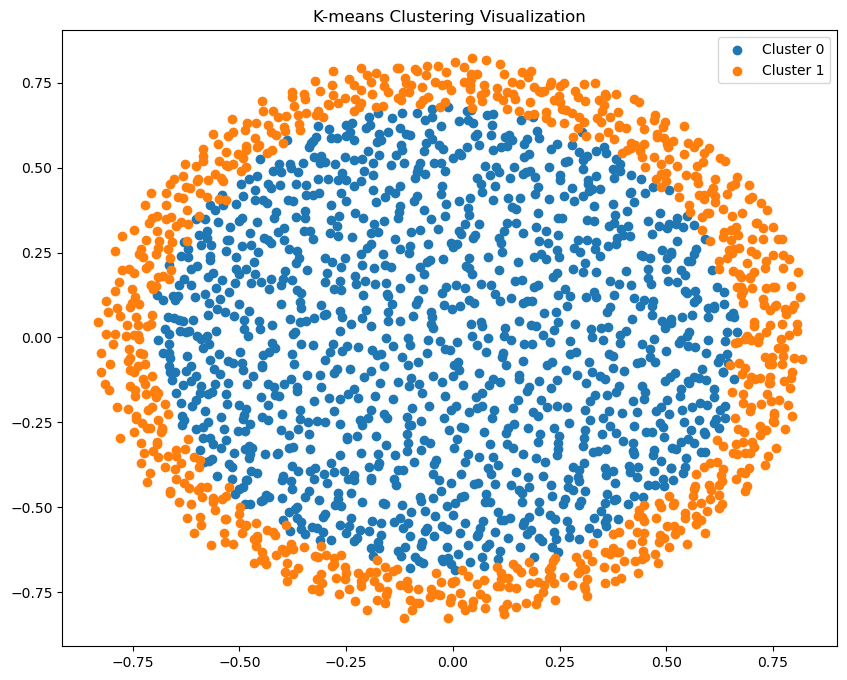

Silhouette Score: 0.1530


In [8]:
# K Means clustering 

# Use sklearn for now just to get a feel for if the method will work in the long run

# Convert the similarity matrix from above into a distance matrix 

# The distance matrix will be 1 - similarity matrix since similarity is between 0 and 1 
from sklearn.metrics import silhouette_score

distance_matrix = 1 - similarity_matrix

# Apply KMeans clustering 
k = 2
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
cluster_labels = kmeans.fit_predict(distance_matrix)

# Add cluster labels to the dataframe 
df['cluster'] = cluster_labels

comparisons_df = pd.DataFrame({
    'cluster': df['cluster'],
    'actual_label': df['label']
})

# Count number of documents in each cluster 

cluster_comparison = pd.crosstab(
  comparisons_df['cluster'], 
  comparisons_df['actual_label'],
  rownames=['Cluster'],
  colnames=['Actual Label'],
)

# Rename the columns for clarity 
cluster_comparison.columns = ['Fake News', 'Real News']
print("Cluster distribution:\n")
print(cluster_comparison)


# You might need to flip the interpretation depending on results
total_docs = len(df)
correct_assignments = cluster_comparison.iloc[0, 0] + cluster_comparison.iloc[1, 1]
accuracy = correct_assignments / total_docs

print(f"Clustering accuracy: {accuracy:.4f}")

# Visualization of clusters (using dimensionality reduction if needed)
from sklearn.manifold import MDS

# Use Multidimensional Scaling to visualize the distance matrix in 2D
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
pos = mds.fit_transform(distance_matrix)

# Plot the clusters
plt.figure(figsize=(10, 8))
for i in range(k):
    # Plot points for this cluster
    cluster_points = pos[cluster_labels == i]
    plt.scatter(
        cluster_points[:, 0], 
        cluster_points[:, 1], 
        label=f'Cluster {i}'
    )

plt.title('K-means Clustering Visualization')
plt.legend()
plt.show()

# Calculate silhouette score to evaluate clustering quality
silhouette_avg = silhouette_score(distance_matrix, cluster_labels)
print(f"Silhouette Score: {silhouette_avg:.4f}")


## Analysis so far

Based on the plot above, there seems to be an alright clustering but right on the decision boundry. The accuracy score is approximately 51%. So,using nothing but similarity of words between datasets, news is clustered into the right category 51% of the time. This leads me to believe that in order to seperate real and fake news we need to understand the context of the news rather than just looking at the raw words themselves. The Silhouette score is a metric used to evaluate how good clustering results are in data clustering. This score is calculated by measuring each data point’s similarity to the cluster it belongs to and how different it is from other clusters. The score ranges from -1 to 1 and where -1 would represent being in the wrong cluster, a score near 0 represents the correct cluster but right on the decision boundry, and a score near 1 represents good clustering. It's formula is: $\frac{(b_{i} - a_{i})}{max(a_{i}, b_{i})} $. We have Silhouette score of 0.1530 which implies overlappinng clusters or data points equallly close to multiple clusters. This makes sense as our accuracy score is around 51%.

#### Compare with a machine learning model 


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Create a TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['processed_content'])
y = df['label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train logistic regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

# Predict
y_pred = lr.predict(X_test)

# Evaluate
print("Logistic Regression Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance - which words are most predictive
feature_names = tfidf.get_feature_names_out()
coef_mag = np.abs(lr.coef_[0])
top_features_idx = coef_mag.argsort()[-50:]  # Top 20 features

print("\nTop predictive words:")
for idx in top_features_idx[::-1]:  # Reverse to get descending order
    print(f"{feature_names[idx]}: {lr.coef_[0][idx]:.4f}")

Logistic Regression Results:
Accuracy: 0.9533

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       293
           1       0.94      0.97      0.96       307

    accuracy                           0.95       600
   macro avg       0.95      0.95      0.95       600
weighted avg       0.95      0.95      0.95       600


Top predictive words:
said: 5.6107
reuters: 4.3259
video: -3.3562
via: -2.0141
image: -1.9661
hillary: -1.9430
washington: 1.7551
tuesday: 1.7248
minister: 1.6761
american: -1.5097
like: -1.4972
gop: -1.4898
thursday: 1.4440
com: -1.4177
watch: -1.4015
black: -1.3653
clinton: -1.3550
featured: -1.3290
tax: 1.3216
america: -1.3177
even: -1.2943
north: 1.2938
spokesman: 1.2378
wednesday: 1.2367
korea: 1.2324
wire: -1.2118
one: -1.2059
senate: 1.1415
eu: 1.1401
china: 1.1259
pic: -1.1181
obama: -1.1137
know: -1.0574
official: 1.0501
monday: 1.0354
gun: -1.0227
percent: 1.0223
statement: 1.0215
repr

### Maybe use GMM and see if there are better results.
### Or could use simple supervised method and compare the results 